# Harry Potter and The Happiness
### a very naive approach in analyzing the sentiment development in the course of a story. 
"Harry Potter and the Philosopher's Stone" was taken as a subject.


## Here is the plot:
1. Download Google Word2Vec pre-trined model (embeddings) [https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing]
2. It is huge and contains tons of garbage. Thus, we retain only a small subset of the words used in the sample text.
3. Having words embedded, we may consider the text as a jiggling trajectory of a "sense" point in 300-dimentional space. 
4. To reveal the underlying "big moves", we're smoothing this trajectory by applying the Moving Average technique.
5. Then, for every point (t) along that trajectory we're calculating the distance (d) to the point corresponding to the word "happy".
6. Plot d(t)
 

## imports, boilerplate

In [1]:
# all we need:

%matplotlib inline

import numpy as np 
import PIL.Image
import pickle
import string
import IPython.display
 
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d

In [2]:
def just_words(filename):
    with open(filename, "r", encoding="utf8") as f:
        txt = f.read() 
        exclude = set(string.punctuation)
        #remove punctuation
        txt = ''.join(ch for ch in txt if ch not in exclude)
        #split into words
        words = txt.split();
        
    return words

## Make Google's Word2Vec subset
Retain the words used in Potter text only.
See [this notebook](Make%20Google's%20Word2Vec%20subset.ipynb)


## Define some functions

In [3]:

def dist (a, b):
#      distance_to_happiness =  (np.linalg.norm(happiness - average_embedding))
    return scipy.spatial.distance.pdist([a,b],'cosine')[0]

def showarray(a, fmt='png'):
    im = a - a.min()
    im = im * (255.0/im.max())

    im = np.uint8(im)
    PIL.Image.fromarray(im).save('out.temp.png', fmt)
    #Yes, it's better to write it into StringIO/BytesIO, but .. 
    IPython.display.display(IPython.display.Image(data='out.temp.png'))
    

def move_average(old_val, new_val, decay=0.9998):
    return old_val*decay + new_val*(1.0-decay);

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

## Read our small subset of Google's Word2Vec emeddings
to make it, run [this notebook](Make%20Google's%20Word2Vec%20subset.ipynb)

In [4]:
with open("potter_embeddings.txt", "rb") as myFile:
    embeddings = pickle.load(myFile)

### Let's look what the "happiness" really is..

In [5]:
print ("ok, happiness is something like %s"%embeddings["happiness"][0:10])
print (np.linalg.norm(embeddings["happiness"]-embeddings["money"]))
print (np.linalg.norm(embeddings["happiness"]-embeddings["love"]))
print (np.linalg.norm(embeddings["happy"]-embeddings["Harry"]))
print (np.linalg.norm(embeddings["happiness"]-embeddings["happy"]))

ok, happiness is something like [ 0.27148438 -0.13183594  0.12890625  0.22070312  0.25585938 -0.05908203
  0.26757812 -0.23828125  0.23828125 -0.0168457 ]
3.79688
3.14097
3.21412
3.35863


## Read the text to analyze

In [6]:
words = just_words("potter.txt");

print ("There are %s words"%(len(words)))
print("sample: %s"%words[0:50]) 

There are 77599 words
sample: ['Harry', 'Potter', 'and', 'the', 'Sorcerers', 'Stone', 'CHAPTER', 'ONE', 'THE', 'BOY', 'WHO', 'LIVED', 'Mr', 'and', 'Mrs', 'Dursley', 'of', 'number', 'four', 'Privet', 'Drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'They', 'were', 'the', 'last', 'people', 'youd', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because']


In [7]:
EMB_SIZE=300;
WORDS_WINDOW=100;

average_embedding = np.ones(EMB_SIZE)
image = np.zeros([EMB_SIZE,0])

#####
happiness = embeddings["happy"]
saddnes = embeddings["sad"]
####

mean_happiness_x=[]  #time
mean_happiness_y=[]   

potter_x=[] #time stamps where "Harry" appears in the thext
potter_y=[]

def get_current_happiness(average_embedding):   
    distance_to_happiness =  dist(happiness, average_embedding)
    
    ## if we're far from saddnes, we're probably happy
    distance_to_saddnes =  dist(saddnes, average_embedding)
     
    return distance_to_saddnes - distance_to_happiness

# Move a really heavy (innertial) point in the embeddings space

In [8]:
 
i = 1
for word in words:
    if word in embeddings:        
        embedding = embeddings[word][0:EMB_SIZE]
        average_embedding = move_average(average_embedding, embedding, 0.9995)
        
        if(word=="Harry" or word=="Potter"):
            # Let's see how far Harry went from The Happinnes            
            potter_x.append(i);
            potter_y.append(get_current_happiness(average_embedding));
        
        if(i % WORDS_WINDOW==0):
            
            mean_happiness_x.append(i);
            mean_happiness_y.append(get_current_happiness(average_embedding));
            
            image=np.c_[ image,  softmax(average_embedding) ]
           
    i+=1

# Plot the smoothed trajectory.
### each column corresponds to 300-dimentional point on a smoothed path.

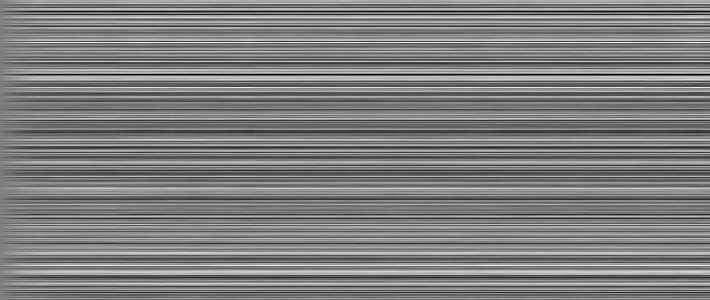

In [9]:
showarray(image)

# Now see how close to the "happiness" was mr. Potter in the course of the story.
(it appears like he has lost his chance after word #38000)


1306


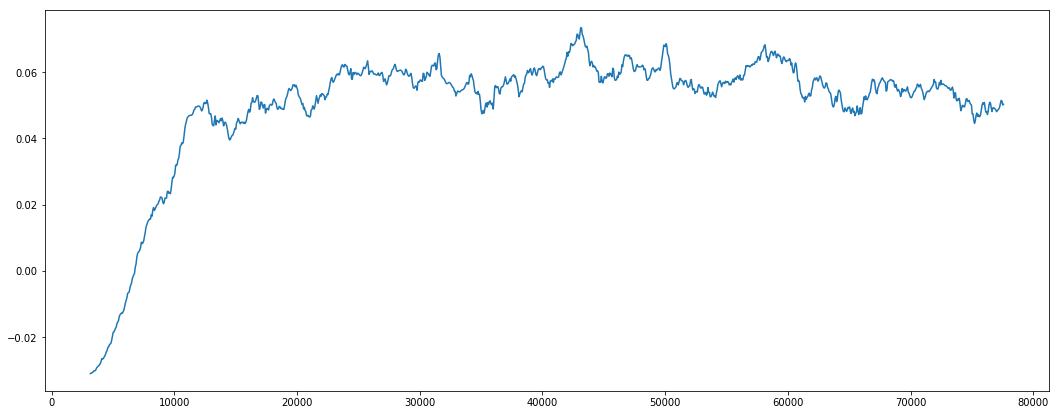

In [10]:
print(len(potter_x)) 

potter_x=potter_x[10:]
potter_y=potter_y[10:]

minx=min(potter_x)
maxx=max(potter_x)

harry_happy_interpol = interp1d(potter_x, potter_y, kind='cubic')

x = np.linspace(minx, maxx, num=1200)

plt.figure(figsize=(18, 7))
#plt.plot( mean_happiness_x, mean_happiness_y, '--') 
plt.plot( x, harry_happy_interpol(x), '-') 

plt.show()